In [1]:
import torch
import torchvision    
import torch.nn as nn                                                   
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import math
import random

# آ

In [2]:
df_train = pd.read_csv('Q3_train.csv')
df_test = pd.read_csv('Q3_test.csv')

y = df_train.iloc[:,0].to_numpy()
X = df_train.iloc[:,1:].to_numpy()
X.shape,y.shape

((27455, 784), (27455,))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


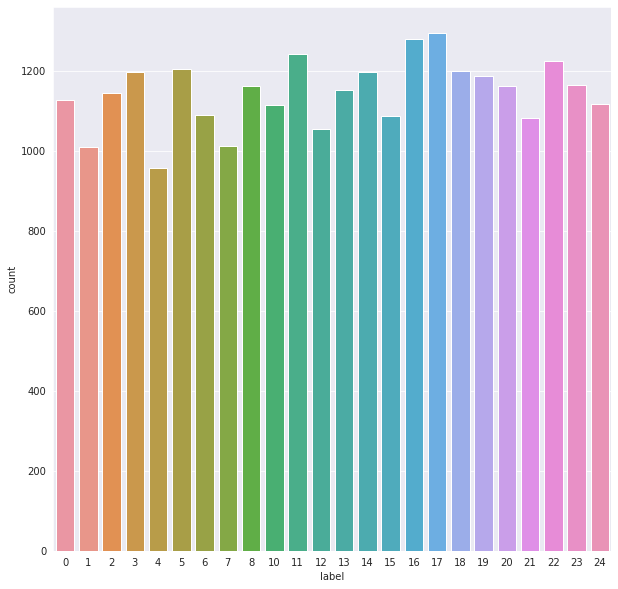

In [3]:
# Label Count
plt.figure(figsize = (10,10)) 
sns.set_style("darkgrid")
sns.countplot(df_train['label'])

In [4]:
#use stratify in case data is not balanced
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((21964, 784), (21964,), (5491, 784), (5491,))

In [5]:
y_test = df_test.iloc[:,0].to_numpy()
X_test = df_test.iloc[:,1:].to_numpy()
X_test.shape,y_test.shape

((7172, 784), (7172,))

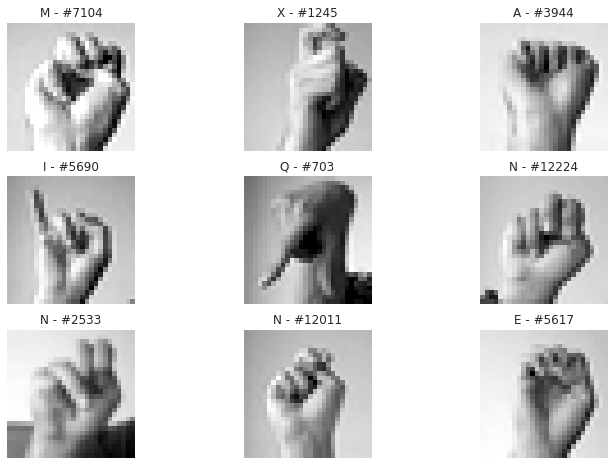

In [6]:
class_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',
              7:'H',8:'I',10:'K',11:'L',12:'M',13:'N',
              14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',
              21:'V',22:'W',23:'X',24:'Y'} #J(9) is not present


def print_images():
  
  fig = plt.figure()
  fig.set_size_inches(fig.get_size_inches() * 2)
  for i in range(9):
    idx = random.randrange(y_train.shape[0])
    img, label = X_train[idx], y_train[idx]
    ax = plt.subplot(3, 3, i+1)
    ax.set_title(class_dict[label] + ' - #' + str(idx))
    ax.axis('off')
    plt.imshow(img.reshape(28,28),cmap='gray')
  plt.show()

print_images()

In [7]:
# Normalize the data
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32')/ 255.
X_test = X_test.astype('float32') / 255.

In [8]:
X_train.shape

(21964, 784)

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, labels, data, transform=None, target_transform=None):
        self.labels = labels
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            label = self.target_transform(label)
        return torch.tensor(x), torch.tensor(label)


train_set = CustomImageDataset(y_train,X_train)
valid_set = CustomImageDataset(y_valid,X_valid)
test_set = CustomImageDataset(y_test,X_test)
len(train_set),len(valid_set),len(test_set)

(21964, 5491, 7172)

In [10]:
type(train_set[0][0])

torch.Tensor

In [11]:
batch_size  = 64   # Using minibatches of 64 samples

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True           
                          )

valid_loader = DataLoader(dataset=valid_set,
                          batch_size=batch_size,
                          shuffle=True           
                          )


test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

# ب

In [117]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            #nn.Linear(512, 256),
            #nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,25)
            #nn.ReLU(),
            #nn.Linear(64,25) #J(9) is not present. classes from 0 to 24
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits
    
model = NeuralNetwork()

In [118]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters()) #default lr = 1e-3

In [73]:
from torch.autograd.grad_mode import no_grad
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(torch.float32))
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss100, current = loss.item(), batch * len(X)
            print(f"loss: {loss100:>7f}  [{current:>5d}/{size:>5d}]")
        with torch.no_grad():
          train_loss += loss.item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    print(f"Train: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss


def valid_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32))
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    print(f"Validation: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    
    return valid_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [70]:
epochs = 30
valid_losses = []
train_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    valid_loss = valid_loop(valid_loader, model, loss_fn)
    valid_losses.append(valid_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 3.212704  [    0/21964]
loss: 2.667382  [ 6400/21964]
loss: 2.139004  [12800/21964]
loss: 1.818952  [19200/21964]
Train: 
 Accuracy: 26.0%, Avg loss: 2.383195 

Validation: 
 Accuracy: 41.9%, Avg loss: 1.810466 

Epoch 2
-------------------------------
loss: 1.639211  [    0/21964]
loss: 1.452777  [ 6400/21964]
loss: 1.288883  [12800/21964]
loss: 1.287770  [19200/21964]
Train: 
 Accuracy: 54.2%, Avg loss: 1.408047 

Validation: 
 Accuracy: 58.3%, Avg loss: 1.243401 

Epoch 3
-------------------------------
loss: 1.319083  [    0/21964]
loss: 0.999640  [ 6400/21964]
loss: 1.026700  [12800/21964]
loss: 0.977750  [19200/21964]
Train: 
 Accuracy: 65.1%, Avg loss: 1.053521 

Validation: 
 Accuracy: 68.7%, Avg loss: 0.917044 

Epoch 4
-------------------------------
loss: 0.866185  [    0/21964]
loss: 1.125034  [ 6400/21964]
loss: 0.746255  [12800/21964]
loss: 0.946896  [19200/21964]
Train: 
 Accuracy: 72.6%, Avg loss: 0.837715 

Validation: 
 Ac

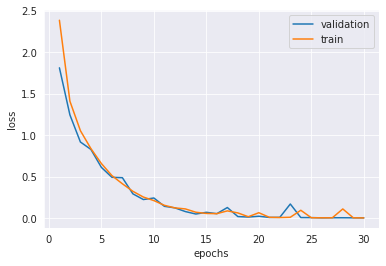

In [71]:
#result with 3 hidden layers
plt.plot(range(1,31),valid_losses,label='validation')
plt.plot(range(1,31),train_losses,label='train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [74]:
test_loop(test_loader, model, loss_fn)

Test: 
 Accuracy: 77.5%, Avg loss: 1.335364 



In [119]:
#SGD
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-2, momentum=0.9)

In [120]:
epochs = 30
valid_losses = []
train_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    valid_loss = valid_loop(valid_loader, model, loss_fn)
    valid_losses.append(valid_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 3.231891  [    0/21964]
loss: 3.123372  [ 6400/21964]
loss: 2.636151  [12800/21964]
loss: 2.041093  [19200/21964]
Train: 
 Accuracy: 19.0%, Avg loss: 2.670308 

Validation: 
 Accuracy: 37.5%, Avg loss: 1.886330 

Epoch 2
-------------------------------
loss: 1.902380  [    0/21964]
loss: 1.899311  [ 6400/21964]
loss: 1.403363  [12800/21964]
loss: 1.445549  [19200/21964]
Train: 
 Accuracy: 48.5%, Avg loss: 1.579972 

Validation: 
 Accuracy: 51.0%, Avg loss: 1.457149 

Epoch 3
-------------------------------
loss: 1.264052  [    0/21964]
loss: 1.031360  [ 6400/21964]
loss: 0.730442  [12800/21964]
loss: 0.737166  [19200/21964]
Train: 
 Accuracy: 64.0%, Avg loss: 1.073498 

Validation: 
 Accuracy: 67.7%, Avg loss: 0.939115 

Epoch 4
-------------------------------
loss: 0.877082  [    0/21964]
loss: 0.742902  [ 6400/21964]
loss: 0.817434  [12800/21964]
loss: 0.705834  [19200/21964]
Train: 
 Accuracy: 74.7%, Avg loss: 0.761478 

Validation: 
 Ac

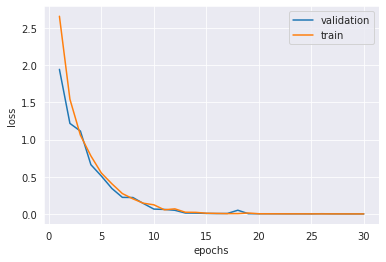

In [82]:
#result with 3 hidden layers
plt.plot(range(1,31),valid_losses,label='validation')
plt.plot(range(1,31),train_losses,label='train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

without momentum and by a higher learing rate than ADAM (0.01 vs. 0.001) 30 epochs were not enough and by the end accuracy on training set was around 80%. Then I added momentum and retrained the model. 
The final result is almost the same as ADAM with validation accuracy and loss in the same order as ADAM's results

In [162]:
test_loop(test_loader, model, loss_fn)

Test: 
 Accuracy: 78.3%, Avg loss: 1.328276 



test accuracy with SGD is slightly better than ADAM's but the difference is not very significant. so we can conclude in our case both optimizers have acceptable results. but generally it is said that although ADAM has faster convergence and more used, SGD with a proper learning rate can have better generalization with more epochs (higher test accuracy)

# ج

In [113]:
from torch.nn.modules.dropout import Dropout
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(28*28, 256),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128,25)

        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits
    
model2 = NeuralNetwork2()

In [88]:
from torch.autograd.grad_mode import no_grad
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(torch.float32))
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss100, current = loss.item(), batch * len(X)
            print(f"loss: {loss100:>7f}  [{current:>5d}/{size:>5d}]")
        with torch.no_grad():
          train_loss += loss.item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    print(f"Train: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss


def valid_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0
    model.eval() #added here because of DropOut
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32))
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    print(f"Validation: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    model.train() #back to train mode for next epoch
    return valid_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [114]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters()) #default lr = 1e-3

In [115]:
epochs = 50
valid_losses = []
train_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model2, loss_fn, optimizer)
    train_losses.append(train_loss)
    valid_loss = valid_loop(valid_loader, model2, loss_fn)
    valid_losses.append(valid_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 3.245490  [    0/21964]
loss: 3.077097  [ 6400/21964]
loss: 2.524020  [12800/21964]
loss: 2.218701  [19200/21964]
Train: 
 Accuracy: 17.1%, Avg loss: 2.666276 

Validation: 
 Accuracy: 38.4%, Avg loss: 1.918644 

Epoch 2
-------------------------------
loss: 1.876626  [    0/21964]
loss: 1.908319  [ 6400/21964]
loss: 1.684477  [12800/21964]
loss: 1.373221  [19200/21964]
Train: 
 Accuracy: 38.6%, Avg loss: 1.824444 

Validation: 
 Accuracy: 53.4%, Avg loss: 1.444121 

Epoch 3
-------------------------------
loss: 1.609698  [    0/21964]
loss: 1.241362  [ 6400/21964]
loss: 1.483492  [12800/21964]
loss: 1.490798  [19200/21964]
Train: 
 Accuracy: 49.1%, Avg loss: 1.495923 

Validation: 
 Accuracy: 60.1%, Avg loss: 1.169909 

Epoch 4
-------------------------------
loss: 1.230710  [    0/21964]
loss: 1.185073  [ 6400/21964]
loss: 1.504191  [12800/21964]
loss: 1.088023  [19200/21964]
Train: 
 Accuracy: 56.0%, Avg loss: 1.274310 

Validation: 
 Ac

In [116]:
test_loop(test_loader, model2, loss_fn)

Test: 
 Accuracy: 75.0%, Avg loss: 1.644493 



1. adding dropout added to model training time. so I added more epochs.
2. train accuracy was lower than validation accuracy in every epoch. it happens because during training some neurons are off and network gives the result with less number of neurons compared to validation where all neurons are on. so the higher the probability of dropout, the more the gap between train and validation graphs.
3. dropout is a kind of regularization so it is used to make higher accuracy score on test data while it lowers accuracy on train data. it can also help overcome overfitting. in our case our model was not overfit(comparing train and validation graphs) so dropout couldn't help in lowering the gap but why test results were not as good as validation results in both parts? (we expected to get better results on test set after adding dropout) it seems that test dataset is more complicated than validation data. so validation data is not a good representative of test data. thus adding dropout didn't help (and for higher p like 0.5 it worsens the result!) probably data augmentation could help make our training and validation data more diverse to overcome this problem.
4. I checked other dropout probabilities:
a. 2 dropout of 0.5 and 0.5 : test accuracy =43%
b. 2 dropout of 0.2 and 0.3 : test accuracy = 77%

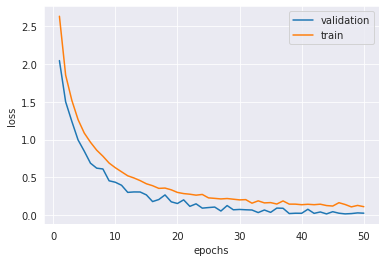

In [112]:
#result with 3 hidden layers
plt.plot(range(1,51),valid_losses,label='validation')
plt.plot(range(1,51),train_losses,label='train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# د

Best result was achieved using SGD: lr =0.01 , momentum = 0.9 and 3 hidden layers of size 784 * 256 - 256 * 128 - 128*25

# ه

In [165]:
# code taken from here https://gist.github.com/ricardodeazambuja/b79724bd0d091fed4c0d44143e9c3127
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image

VIDEO_HTML = """
<div class="video_container">
  <video autoplay
   width=%d height=%d></video>
  <div style='position: absolute;top: 20px; left: 20px; font-size: 20px; color: green;'>Click to save!</div>
</div>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(filename=None, quality=0.9, size=(140,140)):
  handle = display(HTML(VIDEO_HTML % (size[0],size[1],quality)), display_id='videoHTML')
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  if filename:
    f = io.BytesIO(binary)
    Image.open(f).save(filename)
  else:
    f = io.BytesIO(binary)
    img = Image.open(f)
    return np.asarray(img.resize((28,28))) , np.asarray(img)



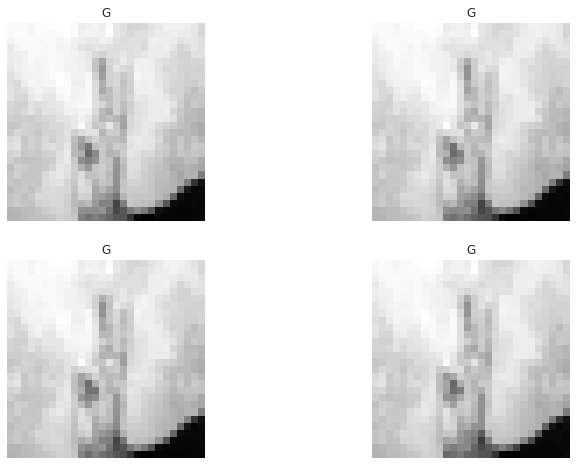

In [168]:
import cv2
import time

fig = plt.figure()
fig.set_size_inches(fig.get_size_inches() * 2)
for i in range(4):
  img_resize , img = take_photo()
  img_gray1 = cv2.cvtColor(img_resize, cv2.COLOR_RGB2GRAY)
  img_gray = img_gray1.reshape((1,28*28))
  img_gray = img_gray.astype('float32') / 255.
  x = torch.from_numpy(img_gray)
  logits = model(x)
  probs = nn.Softmax(dim=1)(logits)
  label = probs.argmax(dim = 1)
  time.sleep(0.05)
  ax = plt.subplot(2, 2, i+1)
  ax.set_title(class_dict[label.item()])
  ax.axis('off')
  plt.imshow(img_gray1,cmap='gray')
plt.show()

it seems the quality of images taken from my webcame is not as good as the dataset so the results are all wrong! so I tried taking pictures with my cell phone:


tensor([[7.7708e-19, 1.4543e-14, 7.4593e-08, 4.2087e-15, 3.4986e-15, 3.0367e-03,
         7.2432e-04, 3.4586e-12, 2.0790e-11, 3.1851e-14, 5.2086e-12, 4.3415e-12,
         1.6881e-10, 1.3201e-09, 6.8396e-04, 9.9539e-01, 1.0562e-04, 1.9715e-17,
         1.8761e-08, 5.4091e-05, 2.6490e-17, 1.8746e-07, 2.6042e-06, 5.8696e-07,
         4.2590e-16]], grad_fn=<SoftmaxBackward0>)
tensor([[2.4184e-15, 1.1190e-15, 6.0595e-06, 2.2778e-10, 3.2468e-14, 9.8430e-01,
         1.2394e-02, 2.2911e-07, 3.9585e-09, 5.9936e-14, 2.1708e-13, 3.9537e-07,
         2.5371e-13, 1.5707e-09, 7.3947e-06, 7.3379e-06, 7.6423e-07, 2.0201e-14,
         2.2694e-10, 2.6945e-03, 1.8484e-16, 1.1672e-07, 2.0516e-09, 5.9264e-04,
         4.4972e-09]], grad_fn=<SoftmaxBackward0>)
tensor([[3.5591e-09, 1.6990e-12, 7.3586e-08, 1.7533e-06, 6.5696e-11, 4.5608e-01,
         2.1308e-02, 7.8626e-04, 1.9126e-03, 7.2619e-11, 1.5521e-10, 2.9059e-09,
         2.8213e-08, 7.4742e-04, 1.3829e-04, 7.3583e-03, 2.1888e-03, 1.2377e-10,
       

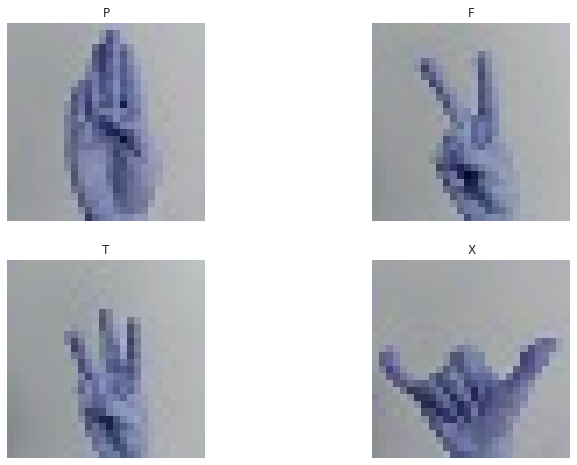

In [185]:
fig = plt.figure()
fig.set_size_inches(fig.get_size_inches() * 2)
for i in range(4):
  img = cv2.imread(str(i)+'.jpg')
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape((1,28*28))
  img_gray = img_gray.astype('float32') / 255.
  x = torch.from_numpy(img_gray)
  logits = model(x)
  probs = nn.Softmax(dim=1)(logits)
  print(probs)
  label = probs.argmax(dim = 1)
  ax = plt.subplot(2, 2, i+1)
  ax.set_title(class_dict[label.item()])
  ax.axis('off')
  plt.imshow(img)
plt.show()

the results are again wrong! maybe the images are not good!